In [1]:
import matplotlib.pyplot as plt
def show(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [2]:
# Import libraries
from plantcv import plantcv as pcv 

class options:
    def __init__(self):
        #self.image = '../../leafsnap/leafsnap-dataset/dataset/images/field/acer_rubrum/13001155906945.jpg'
        self.image = '../images/raws/acer_rubrum/13001155906945.jpg'
        self.debug = "plot"
        self.writeimg= False 
        self.result = "features_metadata.json"
        self.outdir = ""
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug
pcv.params.debug = args.debug

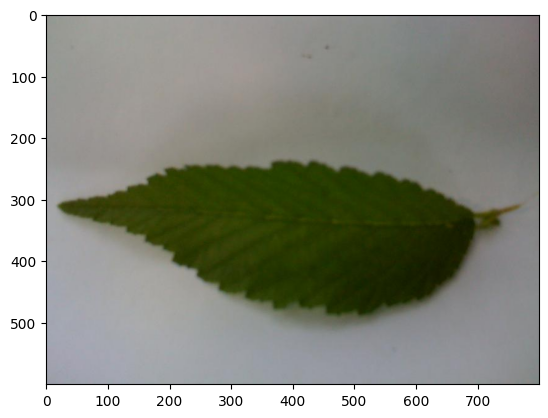

In [3]:
img, path, filename = pcv.readimage(filename=args.image)

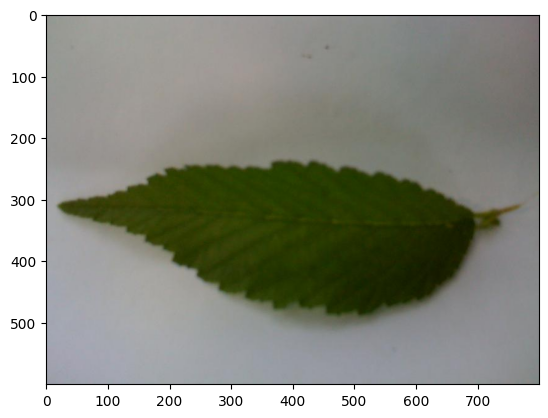

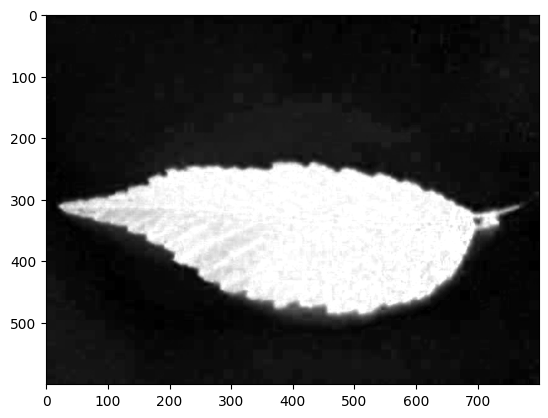

RGB to HSV


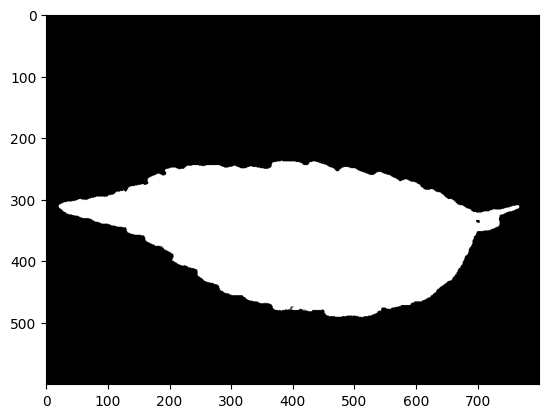

Threshold Saturation Image


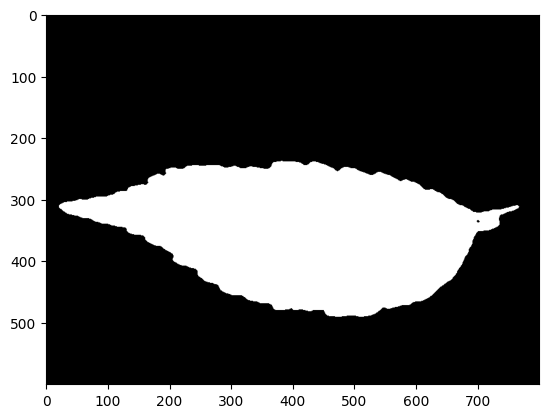

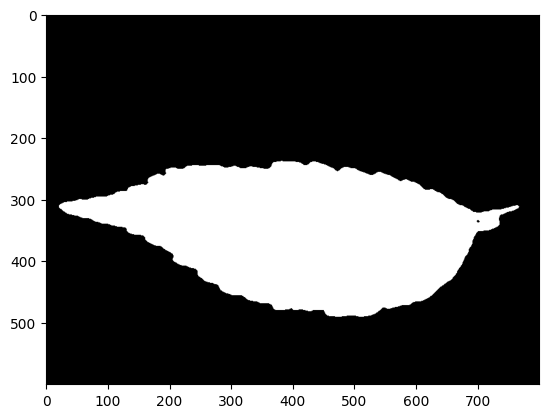

Median Blur


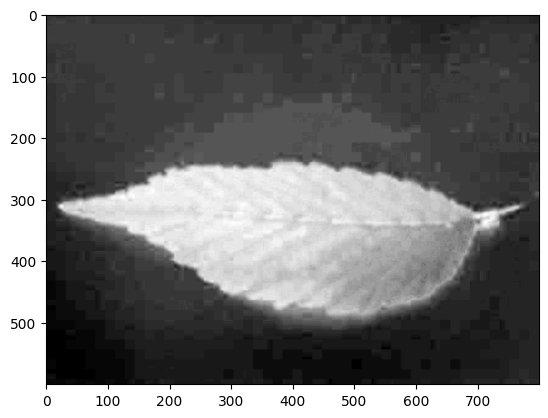

Extract Blue Channel


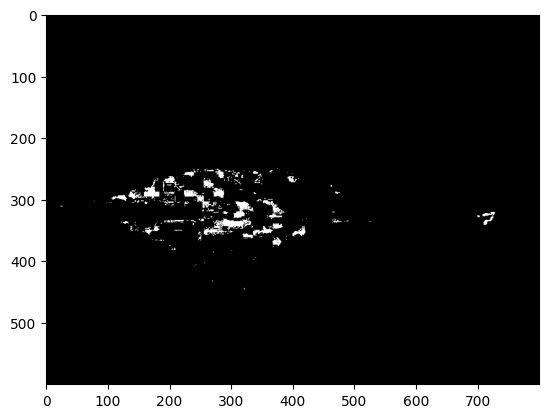

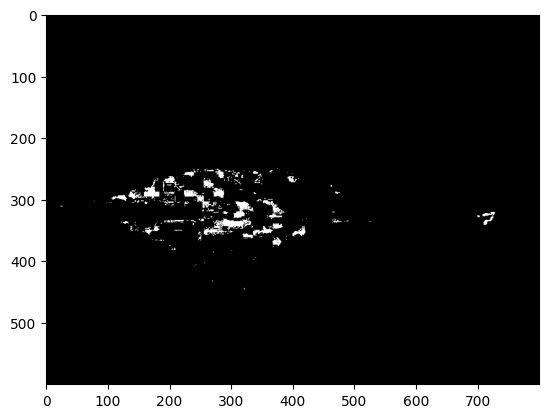

Threshold Blue Image


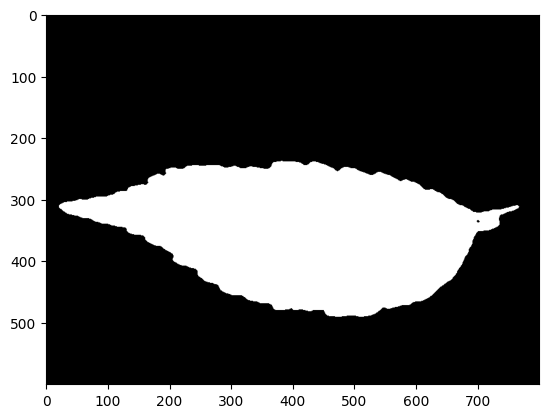

Join Thresholded saturation and blue-yellow imaes


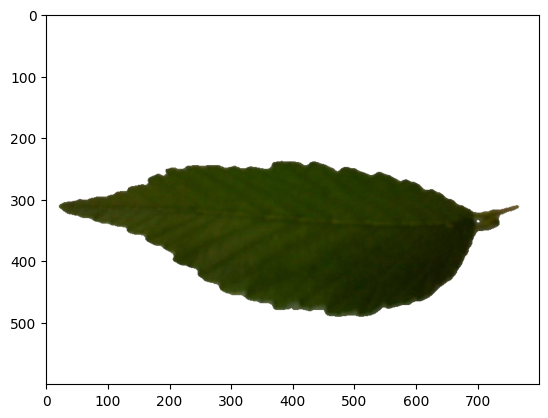

Apply Mask


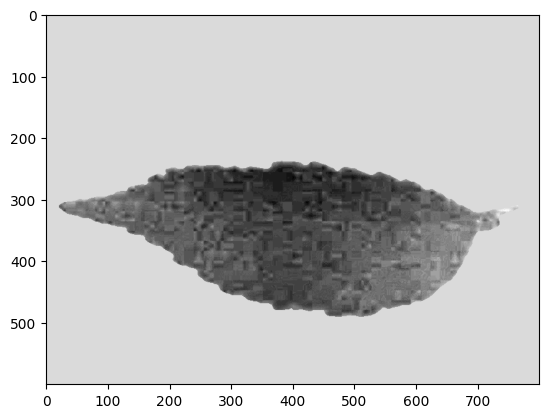

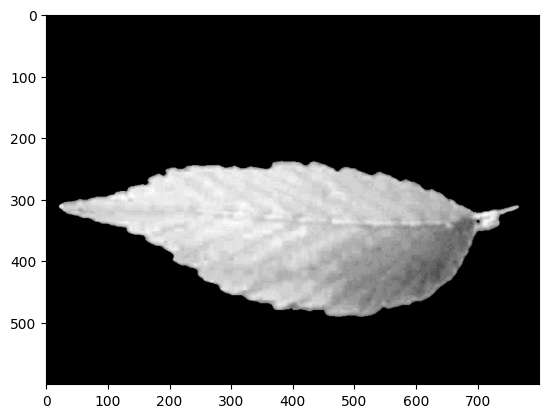

Extract green-magenta and blue-yellow channels


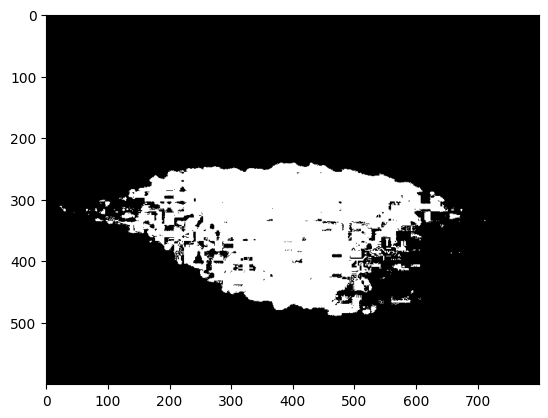

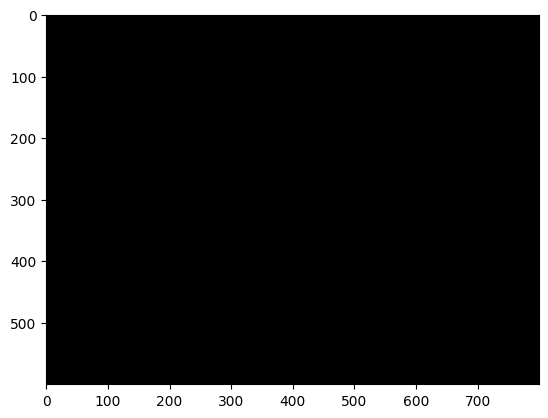

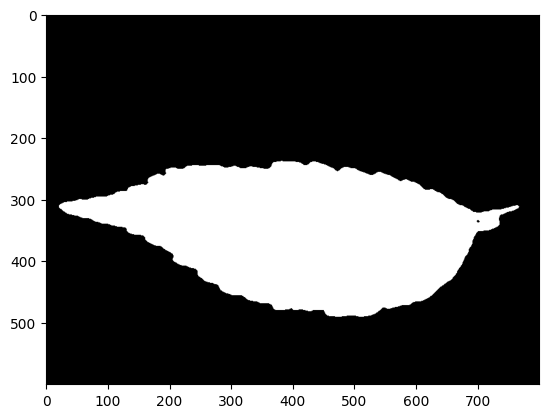

Thresold Green-magenda and blue images


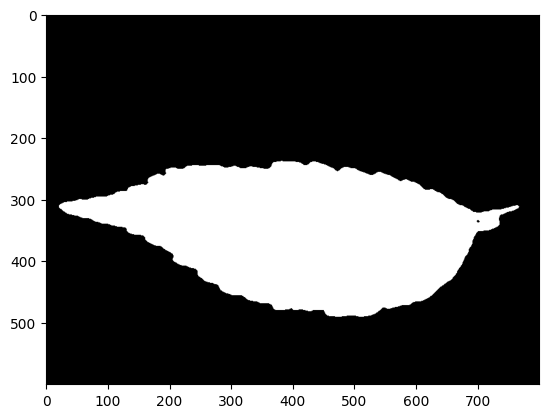

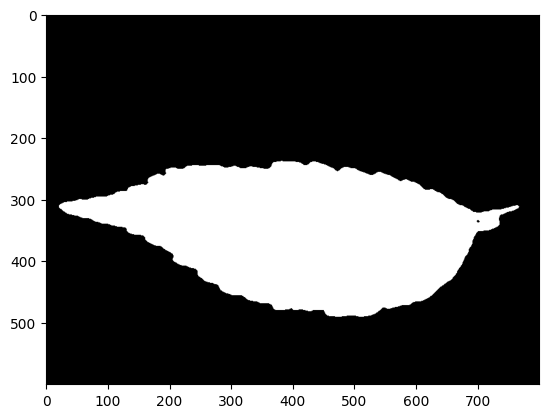

Join Threshold saturation and blue-yellow images


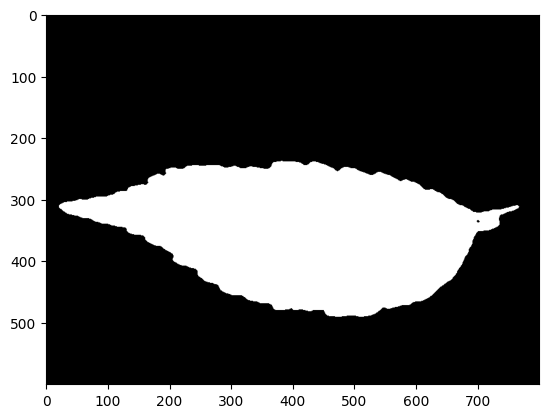

Fill small objects


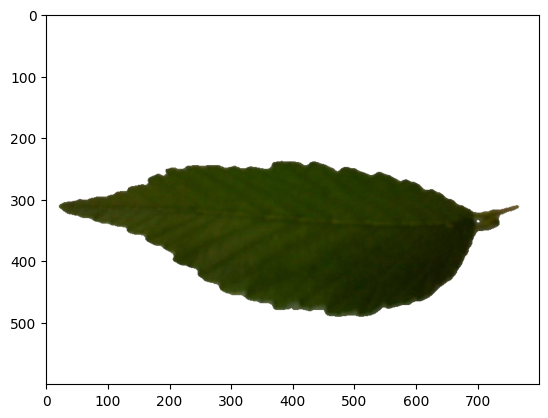

Apply 2nd Masked


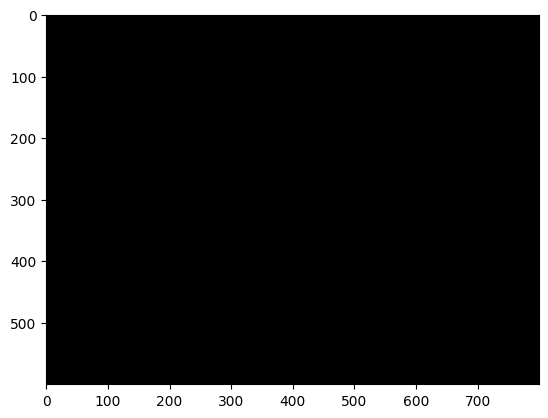

Skeletonize


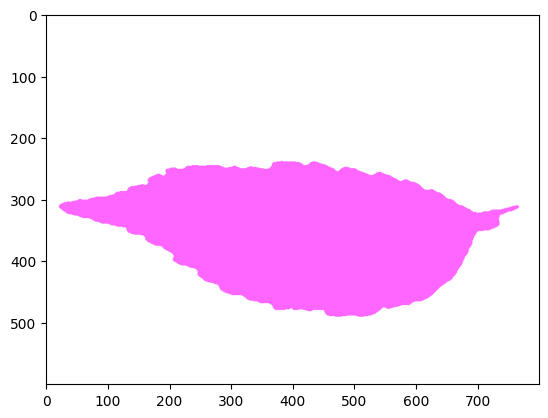

Identify Objects original
Derivative: [ 0.18099418  0.03661165 -0.17888544 ... -0.03555728  0.16055728
  0.32111456]
Integral: 170.24982963200245
Total: 170.24982963200245


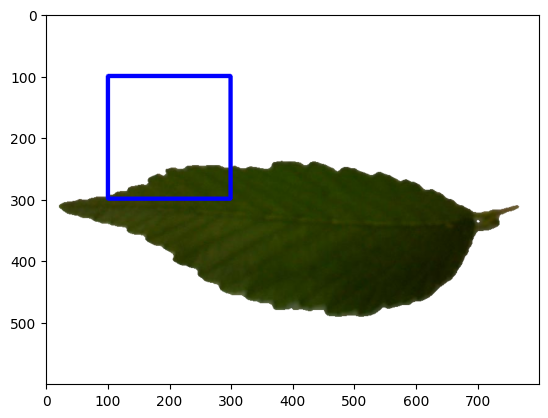

Define Region of Interest


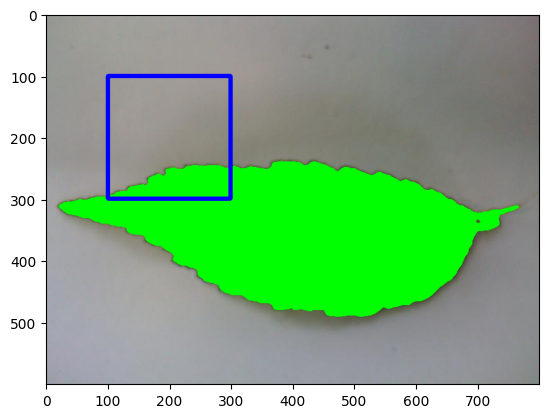

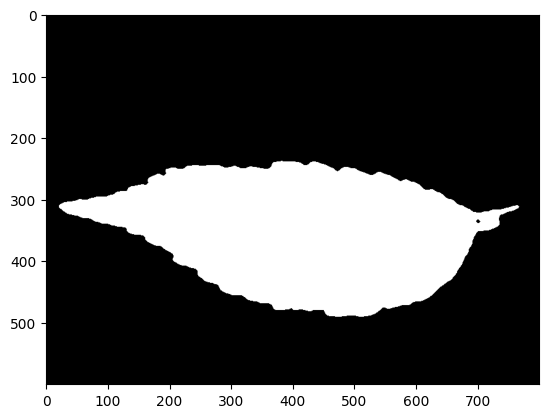

Decide which objects to keep


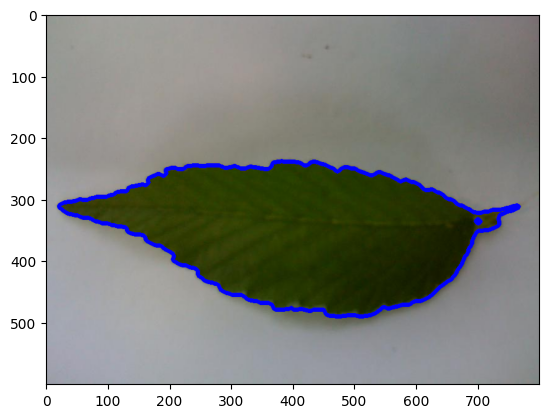

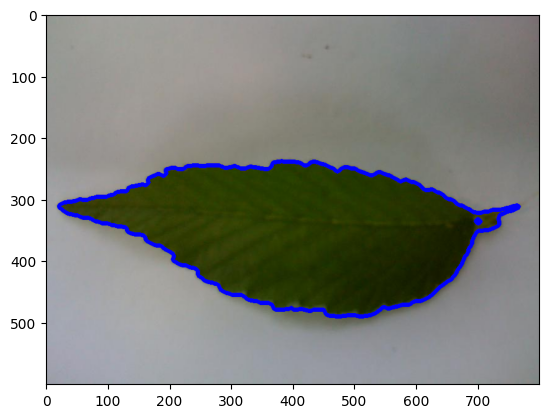

Combine kept objects


In [15]:
import cv2
import numpy as np
from plantcv import plantcv as pcv
import scipy.integrate

# https://www.delftstack.com/howto/numpy/curvature-formula-numpy/
def compute_curvature(x, y): # get circle first // radius points inside 
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / ((dx_dt ** 2 + dy_dt ** 2) ** 1.5)
    return curvature


def compute_curvature_derivative(curvature):
    curvature_derivative = np.gradient(curvature)
    return curvature_derivative


def compute_curvature_integral(curvature):
    curvature_integral = np.trapz(curvature)
    return curvature_integral


img, path, filename = pcv.readimage(filename=args.image)

# Convert RGB to HSV and extract the saturation channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
print("RGB to HSV")

# Threshold the saturation image
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
print("Threshold Saturation Image")

# Median Blur
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)
print("Median Blur")

# Convert RGB to LAB and extract the Blue channel
#b = pcv.rgb2gray_lab(gray_img=img, channel='b')
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
print("Extract Blue Channel")

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')
print("Threshold Blue Image")

# Fill small objects
# b_fill = pcv.fill(b_thresh, 10)

# Join the thresholded saturation and blue-yellow images
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)
print("Join Thresholded saturation and blue-yellow imaes")

# Apply Mask (for VIS images, mask_color=white)
#masked = pcv.apply_mask(rgb_img=img, mask=bs, mask_color='white')
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')
print("Apply Mask")
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
print("Extract green-magenta and blue-yellow channels")

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, max_value=255, object_type='light')
print("Thresold Green-magenda and blue images")

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
print("Join Threshold saturation and blue-yellow images")

# Fill small objects
ab_fill = pcv.fill(bin_img=ab, size=200)
print("Fill small objects")

# Apply mask (for VIS images, mask_color=white)
#masked2 = pcv.apply_mask(rgb_img=masked, mask=ab_fill, mask_color='white')
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')
print("Apply 2nd Masked")

skeleton = pcv.morphology.skeletonize(mask=masked2)
print("Skeletonize")

# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)
print("Identify Objects original")



# Compute curvature of leaf contour
contour = id_objects[0]
curvature = compute_curvature(contour[:,0,0], contour[:,0,1])

# Compute curvature derivative
curvature_derivative = compute_curvature_derivative(curvature)
# Compute curvature integral
curvature_integral = compute_curvature_integral(curvature)
# Total curvature is the absolute value of the curvature integral
total_curvature = np.abs(curvature_integral)

print(f"\n\n\nDerivative: {curvature_derivative}")
print(f"Integral: {str(curvature_integral)}")
print(f"Total: {str(total_curvature)}")





# # Identify objects 2
# id_objects2, obj_hierarchy2 = pcv.find_objects(img=s_thresh, mask=s)
# print("Identify Objects binary")

# # Select the first contour (assuming there is only one)
# contour = id_objects2[0]

# # Fit parabolas to small segments of the contour and compute the curvature at each point
# segment_size = 10
# curvatures = []
# for i in range(segment_size, len(contour) - segment_size, segment_size):
#     x = contour[i-segment_size:i+segment_size+1, 0]
#     y = contour[i-segment_size:i+segment_size+1, 1]
#     a, b, c = pcv.fit_parabola(x, y)
#     curvature = abs(2*a) / ((1 + b**2)**(3/2))
#     curvatures.append(curvature)

# # Compute the curvature derivative for the contour
# curvature_derivative = np.gradient(curvatures)
# # Compute the curvature integral and total curvature for the contour
# curvature_integral = np.trapz(curvatures)
# total_curvature = abs(curvature_integral)

# print("Curvature:", curvatures)
# print("Curvature derivative:", curvature_derivative)
# print("Curvature integral:", curvature_integral)
# print("Total curvature:", total_curvature)




# Define ROI
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=200, w=200)
print("Define Region of Interest")

# Decide which objects to keep
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')
print("Decide which objects to keep")

# Object combine kept objects
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)
print("Combine kept objects")

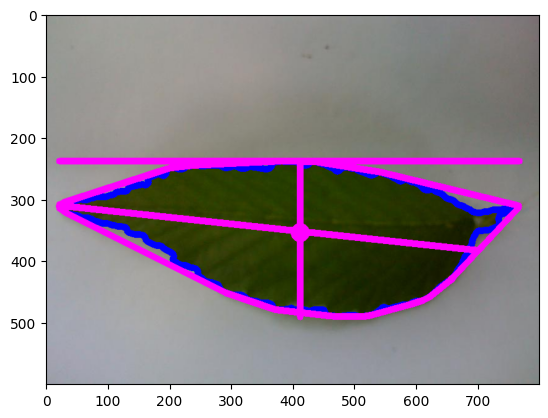

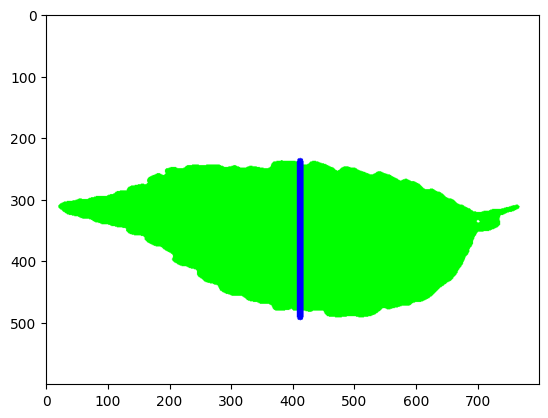

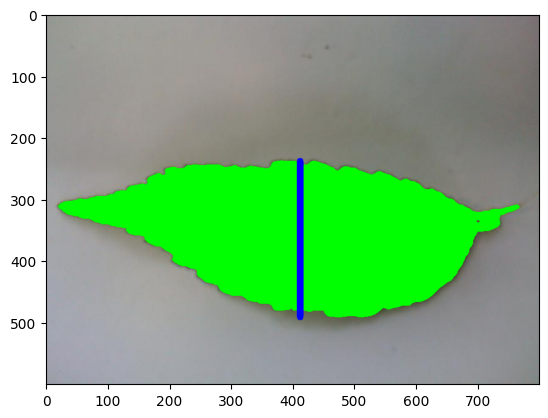

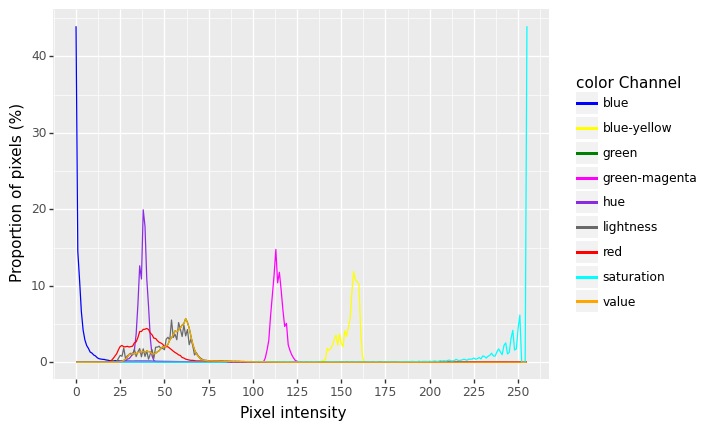

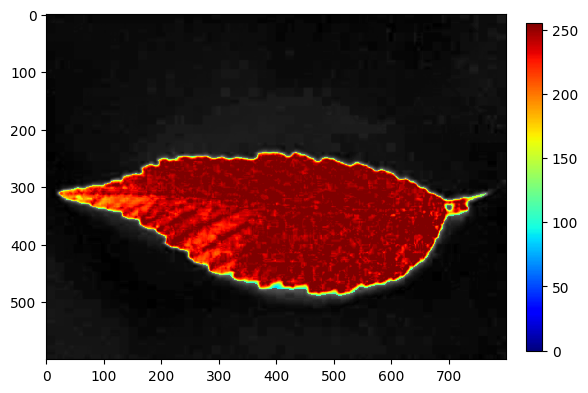

Deprecation warning: plantcv.print_results will be removed in a future version.
             Please use plantcv.outputs.save_results instead.
          


In [46]:
outfile=False
if args.writeimg == True:
    outfile = args.outdir + "/" + filename

# Find shape properties, output shape image (optional)
shape_imgs = pcv.analyze_object(img=img, obj=obj, mask=mask)

# Shape properties relative to user boundary line (optional)
boundary_img1 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, line_position=1680)

# Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)
color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all')

# Pseudocolor the grayscale image
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=s, mask=kept_mask, cmap='jet')

# Write shape and color data to results file
pcv.print_results(filename=args.result)

In [16]:
import plantcv.parallel

config = plantcv.parallel.WorkflowConfig()
config.save_config(config_file="features_workflow.json")

In [18]:
import plantcv.workflow

plantcv.workflow("features_workflow.json")

SyntaxError: invalid syntax (1311840626.py, line 1)

In [47]:
import plantcv.utils

plantcv.utils.json2csv('features_metadata.json', csv_file="results.csv")

ValueError: Invalid JSON file: features_metadata.json